# Setup Instructions
Run the following cell to set up the environment:
1. Clone this repository
2. Install dependencies
3. Run the notebook cells in order

In [ ]:
!git clone https://github.com/farideh-tavakoli/hybrid-ml-machine-behavior.git
%cd hybrid-ml-machine-behavior
!pip install -r requirements.txt

In [ ]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [46]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

In [47]:
df = pd.read_csv("clustering_output_kmeans/sub_3_labeled.csv")

In [48]:
df.columns

Index(['EXE_TotalDuration_min', 'FAIL_TotalDuration_min',
       'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min',
       'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF',
       'N_Change_READY_EXE', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF',
       'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_FAIL_POWER_OFF',
       'N_Change_POWER_OFF_EXE', 'N_Change_POWER_OFF_READY',
       'N_Change_POWER_OFF_FAIL', 'Serial Number', 'Date',
       'Subtechnology_Name_ITA', 'Shipment Date', 'Manufacturing Date',
       'Cluster_Label'],
      dtype='object')

# 4- Modeling
## 4-2- Classification
- After clustering, the identified groups were interpreted and appended to the dataset as categorical labels.  
- These labels were then used as target variables in supervised learning models to predict machine behavioral categories for unseen data.
- Three classification algorithms were evaluated to predict machine behavior categories derived from the clustering phase.  

### Preprocessing Step
It is important to do the same preprocessing steps as the clustring phase.

In [49]:
# Pre_processing steps
columns_to_keep = ['EXE_TotalDuration_min', 'FAIL_TotalDuration_min',
       'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min',
       'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF',
       'N_Change_READY_EXE', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF',
       'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_FAIL_POWER_OFF',
       'N_Change_POWER_OFF_EXE', 'N_Change_POWER_OFF_READY',
       'N_Change_POWER_OFF_FAIL', 'Serial Number', 'Date',
       'Subtechnology_Name_ITA', 'Shipment Date', 'Manufacturing Date',
       'Cluster_Label']

df = df[columns_to_keep].copy()

# impute NULLs in numeric columns with 0
numeric_cols = [
    'EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min',
    'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF',
    'N_Change_READY_EXE', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF',
    'N_Change_FAIL_READY', 'N_Change_FAIL_EXE', 'N_Change_FAIL_POWER_OFF',
    'N_Change_POWER_OFF_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL'
]
df[numeric_cols] = df[numeric_cols].fillna(0)

# convert 'Date' column to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


# Drop rows where all operational durations are zero
columns_to_check = ['EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min']
df = df[~(df[columns_to_check] == 0).all(axis=1)]


# Drop rows with NULLs in these columns
columns_null_to_drop = ["Shipment Date", "Subtechnology_Name_ITA"]
df = df.dropna(subset=columns_null_to_drop, how='any')

# Deduplicate
df = df.drop_duplicates()

# Keep specific subtechnologies
specific_subtechnologies = ['sub_3']
df = df[df['Subtechnology_Name_ITA'].isin(specific_subtechnologies)]

### features (X) and target (y) for classification
- The input features exclude identifiers, metadata, and highly correlated variables that were removed during feature selection in clustering phase.
- The target variable 'Cluster_Label' represents the behavioral category derived from clustering.

In [50]:
X = df.drop(columns=['Serial Number', 'Date', 'Cluster_Label', 'Shipment Date', 'Manufacturing Date',
                     'Subtechnology_Name_ITA','N_Change_READY_EXE', 'N_Change_FAIL_READY', 
                     'N_Change_FAIL_EXE', 'N_Change_POWER_OFF_READY', 'N_Change_POWER_OFF_FAIL'])
y = df["Cluster_Label"]
print(f'Feature Columns: {X.columns.tolist()}')
print(f'Target Column: {y.name}')

Feature Columns: ['EXE_TotalDuration_min', 'FAIL_TotalDuration_min', 'READY_TotalDuration_min', 'POWER_OFF_TotalDuration_min', 'N_Change_EXE_READY', 'N_Change_EXE_FAIL', 'N_Change_EXE_POWER_OFF', 'N_Change_READY_FAIL', 'N_Change_READY_POWER_OFF', 'N_Change_FAIL_POWER_OFF', 'N_Change_POWER_OFF_EXE']
Target Column: Cluster_Label


### Train–Test Split (Hold-Out Method)

- The dataset is split using the hold-out validation approach: 80% for training and 20% for testing.
- Stratified sampling preserves the class distribution of behavioral categories.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

In [52]:
print("Number of training records:", len(X_train))
print("Number of test records:", len(X_test))
print("Number of training labels:", len(y_train))
print("Number of test labels:", len(y_test))

Number of training records: 8793
Number of test records: 2199
Number of training labels: 8793
Number of test labels: 2199


- To prevent data leakage, all models were implemented within a unified `Pipeline` combining feature scaling and the classifier, ensuring that the `MinMaxScaler` was fitted only on the training folds during cross-validation.  
- Model optimization was performed using `GridSearchCV` with stratified 5-fold cross-validation, maximizing the macro-averaged F1-score.  
- Because both missed failure detections (**false negatives**) and false alarms (**false positives**) carry significant operational costs, the F1-score was selected as the primary evaluation metric, balancing precision and recall to ensure reliable performance.

- ach model was evaluated on the test set using accuracy, precision, recall, and weighted F1-score.  
- Confusion matrices were used to visualize class-level performance, while learning curves illustrated model generalization by comparing training and cross-validation scores across varying sample sizes.

- Among all classifiers, the SVM achieved the highest overall F1-score and demonstrated the best balance between bias and variance, making it the final model selected for deployment. 


### Classifier Configurations
#### SVM: 
- Selected for its robustness and effectiveness in high-dimensional spaces.
- Both linear and rbf kernels were tested, with hyperparameters C, gamma, and class weighting (balanced) tuned over logarithmic scales.
#### Decision Tree: 
- Chosen for its interpretability and ability to model non-linear decision boundaries.
- The grid search explored parameters such as criterion (gini, entropy), max_depth, min_samples_split, min_samples_leaf, and max_features.
#### KNN: 
- Used as a distance-based baseline model.
- Hyperparameters including n_neighbors (1–50), weights (uniform, distance), and p (1, 2), corresponding to Manhattan and Euclidean distances, were systematically evaluated.
- Feature scaling with MinMaxScaler ensured fair distance computations.


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Test metrics:
  Accuracy:              0.9941
  Precision (weighted):  0.9942
  Recall (weighted):     0.9941
  F1 (weighted):         0.9941

[SVM] Best params: {'svm__C': 100.0, 'svm__class_weight': None, 'svm__kernel': 'linear'}
[SVM] Best CV f1_macro: 0.9916


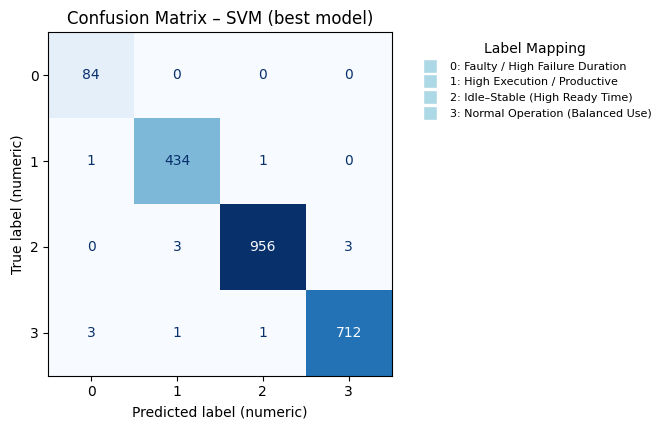

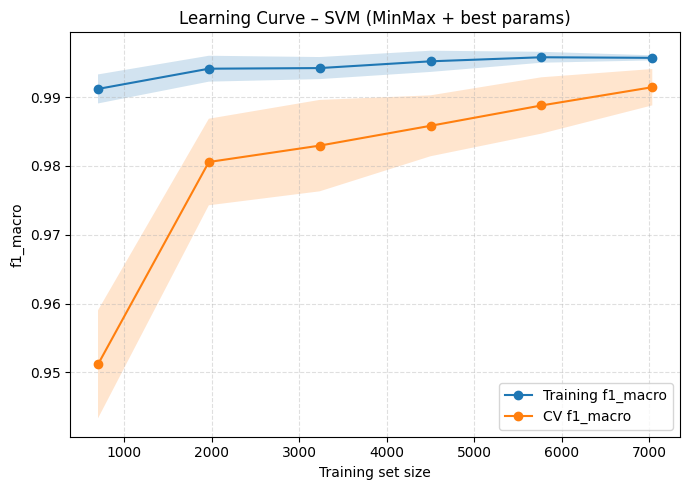

In [54]:
# SVM Classifier with Hyperparameter Tuning

svm_params = [
    {
        "svm__kernel": ["linear"],
        "svm__C": np.logspace(-2, 2, 9),
        "svm__class_weight": [None, "balanced"],
    },
    {
        "svm__kernel": ["rbf"],
        "svm__C": np.logspace(-2, 2, 9),
        "svm__gamma": ["scale"] + list(np.logspace(-3, 1, 9)),
        "svm__class_weight": [None, "balanced"],
    },
]

pipe = Pipeline([
    ("minmax", MinMaxScaler()),
    ("svm", SVC())
])

svm_grid = GridSearchCV(pipe, svm_params, cv=skf, scoring='f1_macro', n_jobs=-1)
svm_grid.fit(X_train, y_train)
best_model_svm = svm_grid.best_estimator_
y_svm_predict = best_model_svm.predict(X_test)



# Test metrics
print("\nTest metrics:")
print("  Accuracy:             ", f"{accuracy_score(y_test, y_svm_predict):.4f}")
print("  Precision (weighted): ", f"{precision_score(y_test, y_svm_predict, average='weighted'):.4f}")
print("  Recall (weighted):    ", f"{recall_score(y_test, y_svm_predict, average='weighted'):.4f}")
print("  F1 (weighted):        ", f"{f1_score(y_test, y_svm_predict, average='weighted'):.4f}")

print("\n[SVM] Best params:", svm_grid.best_params_)
print("[SVM] Best CV f1_macro:", f"{svm_grid.best_score_:.4f}")


# Confusion matrix 
cm_svm = confusion_matrix(y_test, y_svm_predict)

# label mapping
label_map = {
    0: "Faulty / High Failure Duration",
    1: "High Execution / Productive",
    2: "Idle–Stable (High Ready Time)",
    3: "Normal Operation (Balanced Use)"
}
numeric_labels = list(label_map.keys())
fig, ax = plt.subplots(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=numeric_labels)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix – SVM (best model)", fontsize=12)
ax.set_xlabel("Predicted label (numeric)")
ax.set_ylabel("True label (numeric)")
handles = [
    plt.Line2D([0], [0], marker='s', color='w', label=f"{i}: {desc}",
               markerfacecolor='lightblue', markersize=10)
    for i, desc in label_map.items()
]
ax.legend(handles=handles, title="Label Mapping", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=8)
plt.tight_layout()
plt.show()

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model_svm,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring="f1_macro",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6),
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", label="Training f1_macro")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, marker="o", label="CV f1_macro")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("f1_macro")
plt.title("Learning Curve – SVM (MinMax + best params)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 270 candidates, totalling 1350 fits

[Decision Tree] Test metrics:
  Accuracy:              0.9654
  Precision (weighted):  0.9654
  Recall (weighted):     0.9654
  F1 (weighted):         0.9654

[Decision Tree] Best params: {'dt__criterion': 'entropy', 'dt__max_depth': 10, 'dt__max_features': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
[Decision Tree] Best CV f1_macro: 0.9527


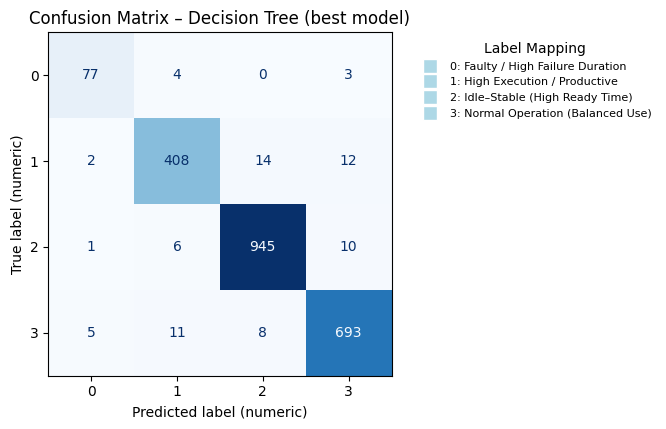

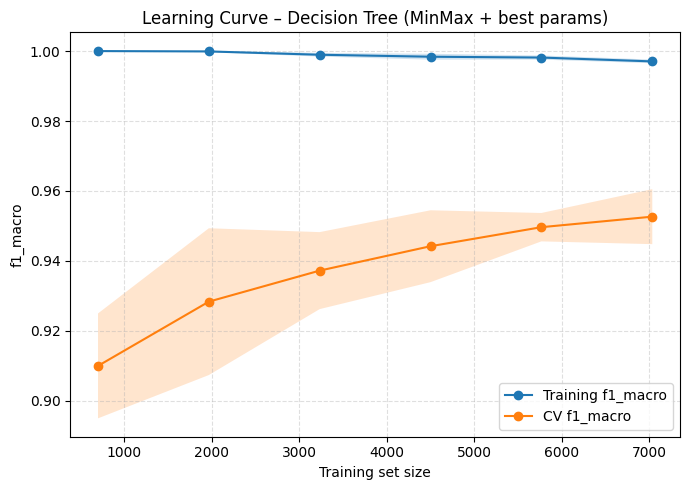


Top 10 most important features:
                    Feature  Importance
    READY_TotalDuration_min        0.46
      EXE_TotalDuration_min        0.35
     FAIL_TotalDuration_min        0.10
POWER_OFF_TotalDuration_min        0.04
         N_Change_EXE_READY        0.02
        N_Change_READY_FAIL        0.01
   N_Change_READY_POWER_OFF        0.01
          N_Change_EXE_FAIL        0.00
    N_Change_FAIL_POWER_OFF        0.00
     N_Change_EXE_POWER_OFF        0.00


/var/folders/57/_z35wjvj6399htfh41br6l1r0000gn/T/ipykernel_90231/1211221489.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp.head(15), palette="viridis")


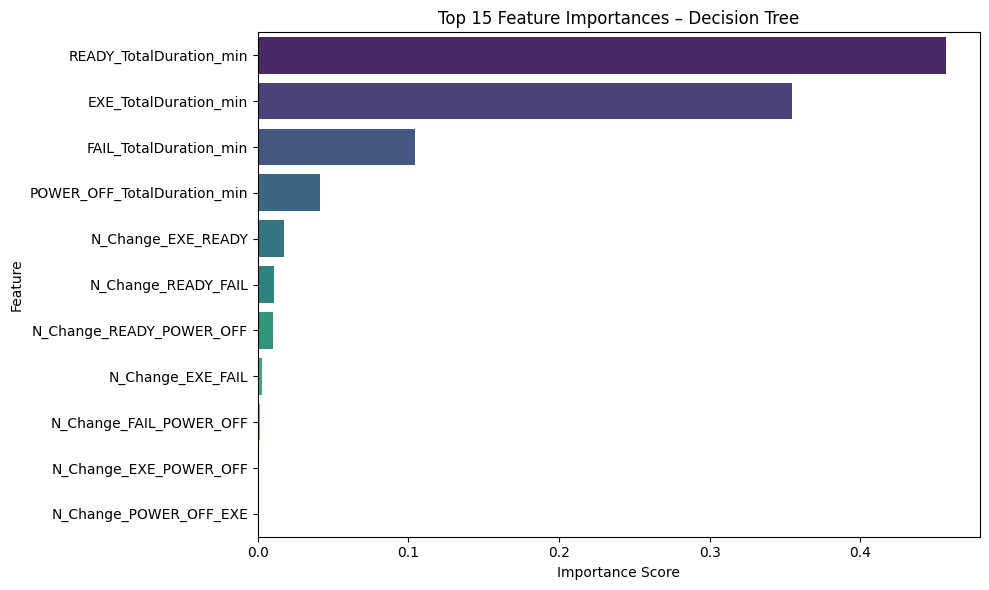

In [55]:
# Decision Tree Classifier with Hyperparameter Tuning

dt_params = [
    {
        "dt__criterion": ["gini", "entropy"],
        "dt__max_depth": [None, 3, 5, 10, 20],
        "dt__min_samples_split": [2, 5, 10],
        "dt__min_samples_leaf": [1, 2, 5],
        "dt__max_features": [None, "sqrt", "log2"],
    }
]

pipe_dt = Pipeline([
    ("minmax", MinMaxScaler()),
    ("dt", DecisionTreeClassifier(random_state=42))
])

dt_grid = GridSearchCV(
    estimator=pipe_dt,
    param_grid=dt_params,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True,
    verbose=1
)

# Fit grid search
dt_grid.fit(X_train, y_train)

# Best model
best_model_dt = dt_grid.best_estimator_
y_dt_predict = best_model_dt.predict(X_test)

# Test metrics
print("\n[Decision Tree] Test metrics:")
print("  Accuracy:             ", f"{accuracy_score(y_test, y_dt_predict):.4f}")
print("  Precision (weighted): ", f"{precision_score(y_test, y_dt_predict, average='weighted'):.4f}")
print("  Recall (weighted):    ", f"{recall_score(y_test, y_dt_predict, average='weighted'):.4f}")
print("  F1 (weighted):        ", f"{f1_score(y_test, y_dt_predict, average='weighted'):.4f}")

print("\n[Decision Tree] Best params:", dt_grid.best_params_)
print("[Decision Tree] Best CV f1_macro:", f"{dt_grid.best_score_:.4f}")


# Confusion matrix
cm_dt = confusion_matrix(y_test, y_dt_predict)

# Label mapping
label_map = {
    0: "Faulty / High Failure Duration",
    1: "High Execution / Productive",
    2: "Idle–Stable (High Ready Time)",
    3: "Normal Operation (Balanced Use)"
}
numeric_labels = list(label_map.keys())
fig, ax = plt.subplots(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=numeric_labels)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix – Decision Tree (best model)", fontsize=12)
ax.set_xlabel("Predicted label (numeric)")
ax.set_ylabel("True label (numeric)")
handles = [
    plt.Line2D([0], [0], marker='s', color='w', label=f"{i}: {desc}",
               markerfacecolor='lightblue', markersize=10)
    for i, desc in label_map.items()
]
ax.legend(handles=handles, title="Label Mapping", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=8)
plt.tight_layout()
plt.show()

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model_dt,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring="f1_macro",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6),
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", label="Training f1_macro")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, marker="o", label="CV f1_macro")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("f1_macro")
plt.title("Learning Curve – Decision Tree (MinMax + best params)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


# Feature Importance
dt_model = best_model_dt.named_steps['dt']
importances = dt_model.feature_importances_
feature_names = X_train.columns

# Create a sorted importance dataframe
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 most important features:")
print(feat_imp.head(10).to_string(index=False))

# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(15), palette="viridis")
plt.title("Top 15 Feature Importances – Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Overfitting because tree memorizes training data perfectly but generalizes less well.
Even with more data, the gap remains large 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits

[KNN] Test metrics:
  Accuracy:              0.9768
  Precision (weighted):  0.9768
  Recall (weighted):     0.9768
  F1 (weighted):         0.9768

[KNN] Best params: {'knn__metric': 'minkowski', 'knn__n_neighbors': 27, 'knn__p': 1, 'knn__weights': 'distance'}
[KNN] Best CV f1_macro: 0.9663


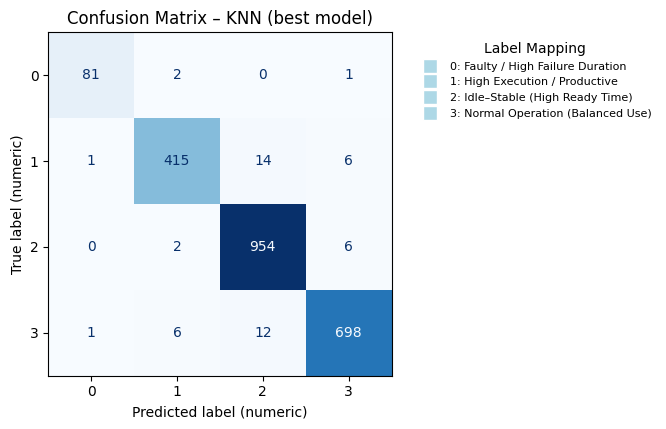

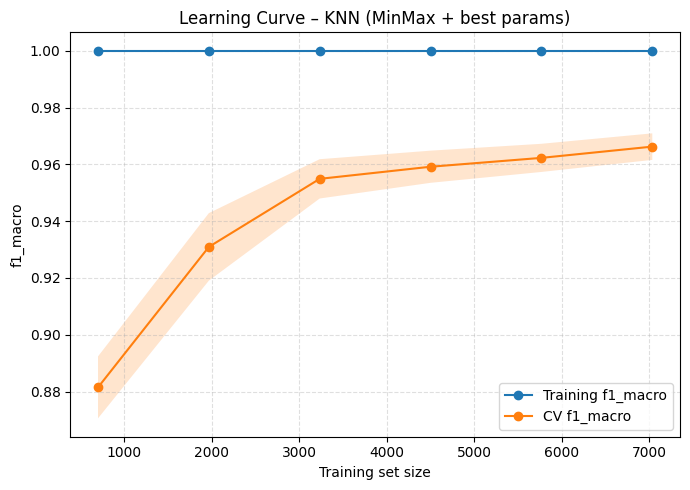

In [56]:
# KNN Classifier with Hyperparameter Tuning

knn_params = [
    {
        "knn__n_neighbors": list(range(1, 51)),
        "knn__weights": ["uniform", "distance"],
        "knn__metric": ["minkowski"],
        "knn__p": [1, 2],
    }
]


pipe_knn = Pipeline([
    ("minmax", MinMaxScaler()),
    ("knn", KNeighborsClassifier())
])


knn_grid = GridSearchCV(
    estimator=pipe_knn,
    param_grid=knn_params,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True,
    verbose=1
)

# Fit and predict
knn_grid.fit(X_train, y_train)
best_model_knn = knn_grid.best_estimator_
y_knn_predict = best_model_knn.predict(X_test)

# Test metrics
print("\n[KNN] Test metrics:")
print("  Accuracy:             ", f"{accuracy_score(y_test, y_knn_predict):.4f}")
print("  Precision (weighted): ", f"{precision_score(y_test, y_knn_predict, average='weighted'):.4f}")
print("  Recall (weighted):    ", f"{recall_score(y_test, y_knn_predict, average='weighted'):.4f}")
print("  F1 (weighted):        ", f"{f1_score(y_test, y_knn_predict, average='weighted'):.4f}")

print("\n[KNN] Best params:", knn_grid.best_params_)
print("[KNN] Best CV f1_macro:", f"{knn_grid.best_score_:.4f}")

# Confusion matrix
cm_knn = confusion_matrix(y_test, y_knn_predict)

# Label mapping
label_map = {
    0: "Faulty / High Failure Duration",
    1: "High Execution / Productive",
    2: "Idle–Stable (High Ready Time)",
    3: "Normal Operation (Balanced Use)"
}
numeric_labels = list(label_map.keys())
fig, ax = plt.subplots(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=numeric_labels)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix – KNN (best model)", fontsize=12)
ax.set_xlabel("Predicted label (numeric)")
ax.set_ylabel("True label (numeric)")
handles = [
    plt.Line2D([0], [0], marker='s', color='w', label=f"{i}: {desc}",
               markerfacecolor='lightblue', markersize=10)
    for i, desc in label_map.items()
]
ax.legend(handles=handles, title="Label Mapping", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=8)
plt.tight_layout()
plt.show()

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model_knn,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring="f1_macro",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6),
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", label="Training f1_macro")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, marker="o", label="CV f1_macro")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("f1_macro")
plt.title("Learning Curve – KNN (MinMax + best params)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

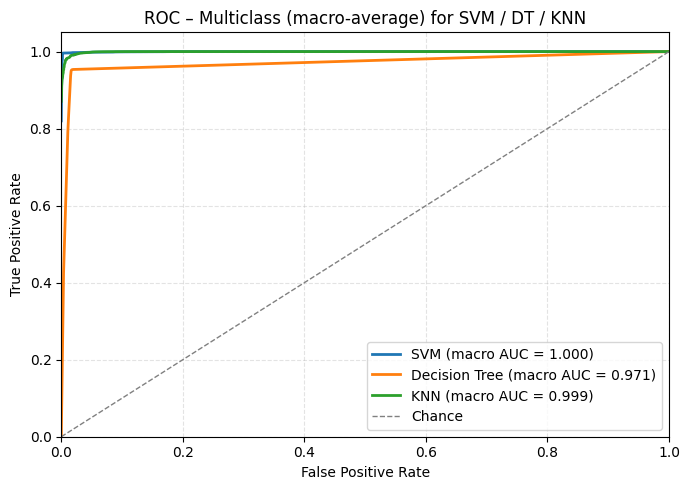

In [57]:
# ROC Curve

# ---- helper: get class scores matrix (n_samples x n_classes) ----
def model_scores(model, X):
    """
    Returns scores per class for ROC:
    - uses predict_proba if available
    - otherwise uses decision_function (e.g., SVM without probability=True)
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)
    elif hasattr(model, "decision_function"):
        s = model.decision_function(X)
        # For binary, decision_function returns shape (n_samples,), convert to (n_samples, 2)
        if s.ndim == 1:
            s = np.vstack([-s, s]).T
        return s
    else:
        raise ValueError("Model must have predict_proba or decision_function for ROC.")

# ---- main: plot macro-average ROC for multiple models ----
def plot_roc_three_models(best_model_svm, best_model_dt, best_model_knn, X_test, y_test):
    # Fix a consistent class order
    classes = np.unique(y_test)
    y_bin = label_binarize(y_test, classes=classes)
    n_classes = y_bin.shape[1]

    models = {
        "SVM": best_model_svm,
        "Decision Tree": best_model_dt,
        "KNN": best_model_knn
    }

    plt.figure(figsize=(7, 5))

    for name, model in models.items():
        scores = model_scores(model, X_test)  # shape (n_samples, n_classes)
        # ensure column order matches 'classes' if estimator keeps a .classes_ attribute
        if hasattr(model, "classes_"):
            # pipeline exposes classes_ on final estimator
            order = np.array([np.where(model.classes_ == c)[0][0] for c in classes])
            scores = scores[:, order]

        # per-class ROC and AUC
        fpr = dict(); tpr = dict(); roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # macro-average ROC
        # 1) collect all FPR points
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # 2) interpolate TPR for each class on all_fpr and average
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        macro_auc = auc(all_fpr, mean_tpr)

        plt.plot(all_fpr, mean_tpr, lw=2, label=f"{name} (macro AUC = {macro_auc:.3f})")

    # chance line
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1, label="Chance")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC – Multiclass (macro-average) for SVM / DT / KNN")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.35)
    plt.tight_layout()
    plt.show()


plot_roc_three_models(best_model_svm, best_model_dt, best_model_knn, X_test, y_test)

- The optimized SVM pipeline, including the feature scaling step, was saved using `joblib` for reproducibility and deployment.  
- This integrated pipeline allows new IoT machine data to be directly scaled and classified into behavioral categories.

In [59]:
# Save the SVM model (scaler + SVM with best hyperparameters)
save_folder = "model"
os.makedirs(save_folder, exist_ok=True)
model_path = os.path.join(save_folder, "svm_best_pipeline.pkl")
joblib.dump(best_model_svm, model_path)
print(f"Model saved successfully at: {model_path}")

Model saved successfully at: model/svm_best_pipeline.pkl


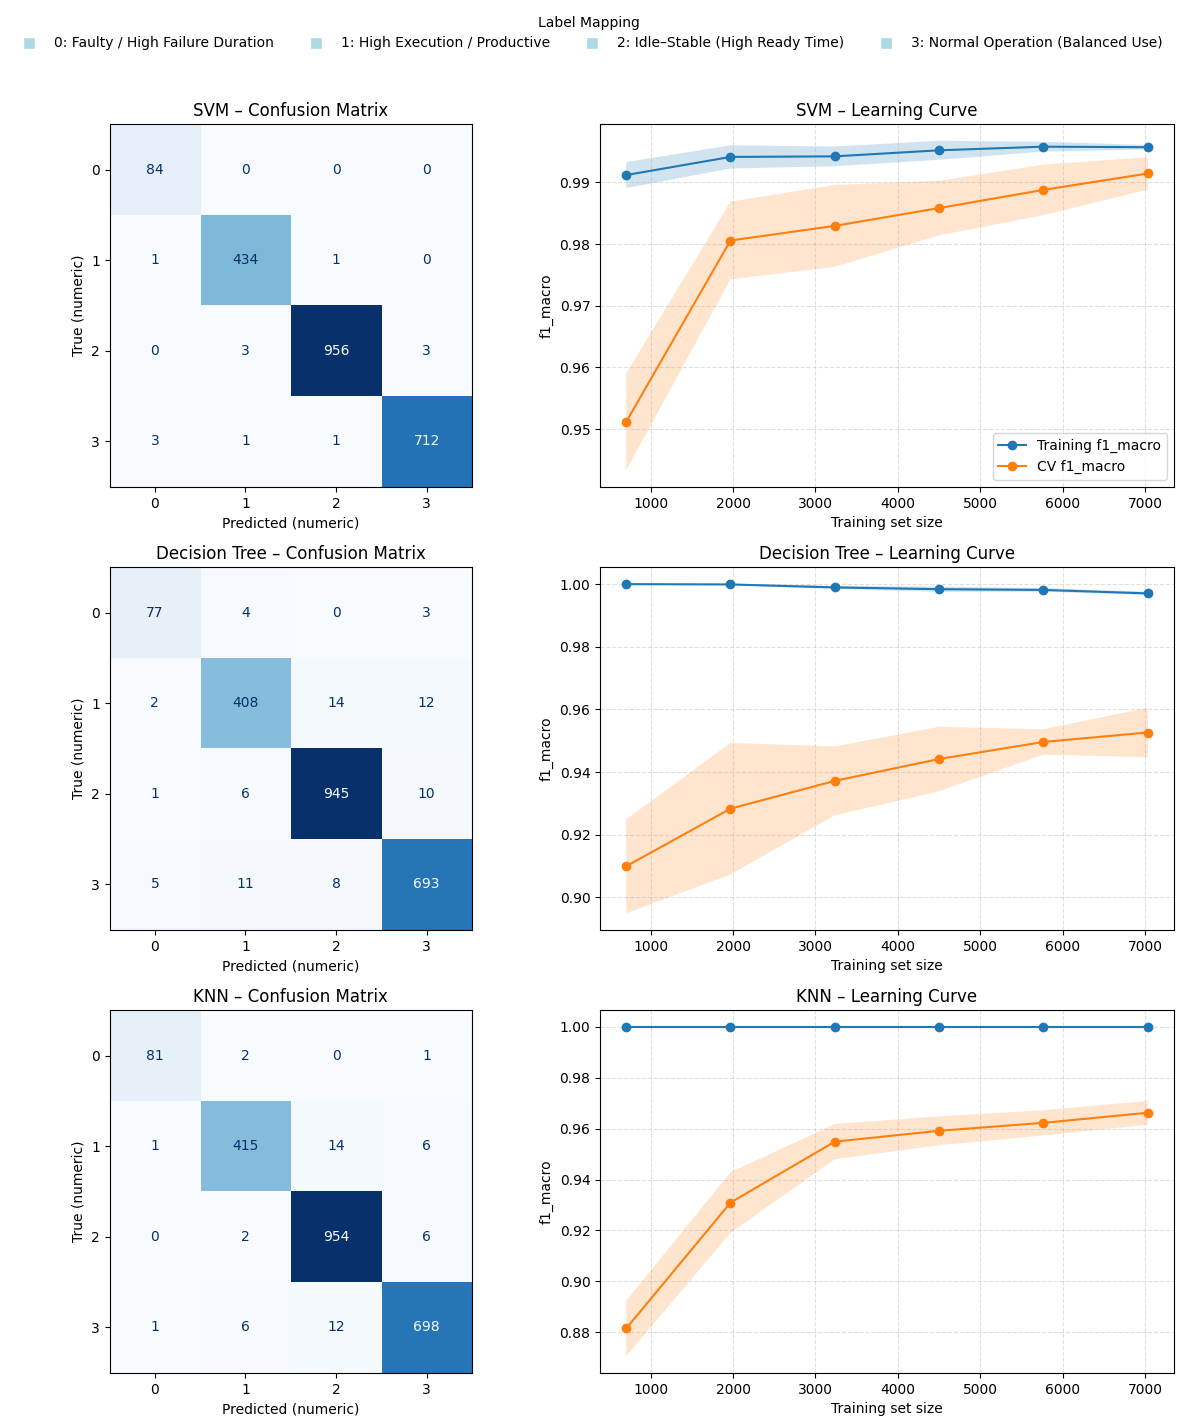

In [ ]:
label_map = {
    0: "Faulty / High Failure Duration",
    1: "High Execution / Productive",
    2: "Idle–Stable (High Ready Time)",
    3: "Normal Operation (Balanced Use)"
}
numeric_labels = list(label_map.keys())


models = [
    ("SVM", best_model_svm, y_svm_predict),
    ("Decision Tree", best_model_dt, y_dt_predict),
    ("KNN", best_model_knn, y_knn_predict),
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

for row, (name, est, y_pred) in enumerate(models):

    ax_cm = axes[row, 0]
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=numeric_labels,
        cmap="Blues", colorbar=False, ax=ax_cm
    )
    ax_cm.set_title(f"{name} – Confusion Matrix")
    ax_cm.set_xlabel("Predicted (numeric)")
    ax_cm.set_ylabel("True (numeric)")


    ax_lc = axes[row, 1]
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=est,
        X=X_train, y=y_train,
        cv=skf,
        scoring="f1_macro",
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 6),
        shuffle=True, random_state=42
    )
    train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
    val_mean,   val_std   = val_scores.mean(axis=1),   val_scores.std(axis=1)

    ax_lc.plot(train_sizes, train_mean, marker="o", label="Training f1_macro")
    ax_lc.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
    ax_lc.plot(train_sizes, val_mean, marker="o", label="CV f1_macro")
    ax_lc.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
    ax_lc.set_title(f"{name} – Learning Curve")
    ax_lc.set_xlabel("Training set size")
    ax_lc.set_ylabel("f1_macro")
    ax_lc.grid(True, linestyle="--", alpha=0.4)
    if row == 0:
        ax_lc.legend(loc="lower right")

handles = [
    plt.Line2D([0], [0], marker='s', color='w',
               label=f"{i}: {desc}",
               markerfacecolor='lightblue', markersize=9)
    for i, desc in label_map.items()
]
fig.legend(handles=handles, title="Label Mapping",
           loc="upper center", ncol=4, frameon=False,
           bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()